### Packages 

In [1]:
# system packages
import sys
import time
import warnings
import os
from collections import Counter

# non-geo numeric packages
import multiprocess.pool as mp
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import product, combinations
import pandas as pd

# network and OSM packages
import networkx as nx
import osmnx as ox
city_geo = ox.geocoder.geocode_to_gdf

# Earth engine packages
import ee
import geemap

# General geo-packages
from rasterstats import zonal_stats
from pyproj import CRS
import libpysal
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point, MultiLineString, LineString, Polygon, MultiPolygon

In [2]:
# latest gdf
popgridmanchester = gpd.read_file('popgridmanchester3.gpkg')

### GEE auth/initialisation, loading health outcome data, extracting population grid data

In [ ]:
# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
ee.Initialize()

In [ ]:
# Provided dataset including health outcomes
data = gpd.read_file("/Users/Julian/Desktop/Julian/PSY/Thesis/data/Greater_Manchester_NH_GIS.gpkg")

In [ ]:
# Health outcome only
data_health = data[['geometry','lsoa11cd','UNID','lsoa11nm','ID','lon','lat','Yrpotlife','Comilldis','Obes_Per_Obesprev_y15', 'Asthma_Per_Asthmaprev_y17', 'heart_Per_heartdiseaseprev_y17', 'Stroke_Per_Strokeprev_y17', 'Cancer_Per_cancerPrev_y17', 'samhi_index2019', 'prop_ibesa', 'est_qof_dep', 'antidep_rate']]


In [ ]:
# specify cities using the excel files with the cities and iso's

# Extract iso-3166 country codes
iso = pd.read_excel('/Users/Julian/Desktop/Julian/PSY/Thesis/data/iso_countries.xlsx')

# Extract cities list
cities = pd.read_excel('/Users/Julian/Desktop/Julian/PSY/Thesis/data/cities.xlsx') # all cities

# 'cities_adj' serves by default as city-input for functions
cities_adj = cities[cities['City'].isin(['Manchester'])]
cities_adj = cities_adj.reset_index()

In [467]:
# function to extract worldpop data from GEE of the cities
def gee_worldpop_extract (city_file, iso, save_path = None):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = [cities[cities['City'] == city]['OSM_area'].tolist()[0].rsplit(', ') for city in cities['City'].tolist()]

    # Get the city geoms
    obj = [city_geo(city).dissolve()['geometry'].tolist()[0] for city in OSM_incl]
    
    # Get the city countries
    obj_displ = [city_geo(city).dissolve()['display_name'].tolist()[0].rsplit(', ')[-1]for city in OSM_incl]
    obj_displ = np.where(pd.Series(obj_displ).str.contains("Ivoire"),"CIte dIvoire",obj_displ)

    # Get the country's iso-code
    iso_list = [iso[iso['name'] == ob]['alpha3'].tolist()[0] for ob in obj_displ]

    # Based on the iso-code return the worldpop 2020
    ee_worldpop = [ee.ImageCollection("WorldPop/GP/100m/pop")\
        .filter(ee.Filter.date('2020'))\
        .filter(ee.Filter.inList('country', [io])).first() for io in iso_list]

    # Clip the countries with the city geoms.
    clipped = [ee_worldpop[i].clip(shapely.geometry.mapping(obj[i])) for i in range(0,len(obj))]

    # Create path if non-existent
    if save_path == None:
        path = ''
    else:
        path = save_path
        if not os.path.exists(path):
                    os.makedirs(path)

    # Export as TIFF file.
    # Stored in form path + USA_Los Angeles_2020.tif
    filenames = [path+iso_list[i]+'_'+cities['City'][i]+'_2020.tif' for i in range(len(obj))]
    [geemap.ee_export_image(clipped[i], filename = filenames[i]) for i in range(0,len(obj))]
    return(filenames)
    sys.stdout.flush()

In [ ]:
# Now grid based on the 27700 CRS

# function to create population grids of the cities
def city_grids_format(city_grids, cities_area, grid_size = 100):
    start_time = time.time()
    grids = []
    print(str(grid_size) + 'm resolution grids extraction')
    for i in range(len(city_grids)):
        
        # Open the raster file
        with rasterio.open(city_grids[i]) as src:
            band= src.read() # the population values
            aff = src.transform # the raster bounds and size (affine)
        
        # Get the rowwise arrays, get a 2D dataframe
        grid = pd.DataFrame()
        for b in enumerate(band[0]):
            grid = pd.concat([grid, pd.Series(b[1],name=b[0])],axis=1)
        grid= grid.unstack().reset_index()
        
        # Unstack df to columns
        grid.columns = ['row','col','value']
        grid['minx'] = aff[2]+aff[0]*grid['col']
        grid['miny'] = aff[5]+aff[4]*grid['row']
        grid['maxx'] = aff[2]+aff[0]*grid['col']+aff[0]
        grid['maxy'] = aff[5]+aff[4]*grid['row']+aff[4]
        
        # Create polygon from affine bounds and row/col indices
        grid['geometry'] = [Polygon([(grid.minx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.miny[i]),
                                   (grid.maxx[i],grid.maxy[i]),
                                   (grid.minx[i],grid.maxy[i])])\
                          for i in range(len(grid))]
        
        # Set the df as geo-df
        grid = gpd.GeoDataFrame(grid, crs = 27700) 

        # Get dissolvement_key for dissolvement. 
        grid['row3'] = np.floor(grid['row']/(grid_size/100)).astype(int)
        grid['col3'] = np.floor(grid['col']/(grid_size/100)).astype(int)
        grid['dissolve_key'] = grid['row3'].astype(str) +'-'+ grid['col3'].astype(str)
        
        # Define a city's OSM area as Polygon.
        geo_ls = gpd.GeoSeries(city_geo(cities_area[i].split(', ')).dissolve().geometry)
        geo_ls = geo_ls.to_crs("EPSG:27700")
        
        # Intersect grids with the city boundary Polygon.
        insec = grid.intersection(geo_ls.tolist()[0])
        
        # Exclude grids outside the specified city boundaries
        insec = insec[insec.area > 0]
        
        # Join in other information.
        insec = gpd.GeoDataFrame(geometry = insec, crs = 27700).join(grid.loc[:, grid.columns != 'geometry'])
        
        # Dissolve into block by block grids
        popgrid = insec[['dissolve_key','geometry','row3','col3']].dissolve('dissolve_key')
        
        # Get those grids populations and area, only full blocks
        popgrid['population'] = round(insec.groupby('dissolve_key')['value'].sum()).astype(int)
        #popgrid['area_m'] = round(gpd.GeoSeries(popgrid['geometry'], crs = 27700).to_crs(3043).area).astype(int)
        popgrid = popgrid[popgrid['population'] >= 0]
        #popgrid = popgrid[popgrid['area_m'] / popgrid['area_m'].max() > 0.95]

        # Get centroids and coords
        popgrid['centroid'] = popgrid['geometry'].centroid
        #popgrid['centroid_m'] = gpd.GeoSeries(popgrid['centroid'], crs = '27700').to_crs(3043)
        popgrid['grid_lon'] = popgrid['centroid'].x
        popgrid['grid_lat'] = popgrid['centroid'].y
        popgrid = popgrid.reset_index()

        minx = popgrid.bounds['minx']
        maxx = popgrid.bounds['maxx']
        miny = popgrid.bounds['miny']
        maxy = popgrid.bounds['maxy']

        # Some geometries result in a multipolygon when dissolving (like i.e. 0.05 meters), coords error.
        # Therefore recreate the polygon.
        Poly = []
        for k in range(len(popgrid)):
            Poly.append(Polygon([(minx[k],maxy[k]),(maxx[k],maxy[k]),(maxx[k],miny[k]),(minx[k],miny[k])]))
        popgrid['geometry'] = Poly

        grids.append(popgrid)

        print(city_grids[i].rsplit('_')[3], round((time.time() - start_time)/60,2),'mns')
    return(grids)

In [ ]:
# Required preprocess for information extraction
warnings.filterwarnings('ignore')

# In essence, we use Google Earth Engine to extract a country's grid raster and clip it with the city's preferred OSM area
# Predifine in Excel: the (1) city name as "City" and (2) the OSM area that needs to be extracted as "OSM_area"
# i.e. City = "Los Angeles" and OSM_area = "Los Angeles county, Orange county CA"
files = gee_worldpop_extract(cities_adj, iso, '/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/')

# Files are downloaded automatically to the specified path. Files are also stored in Google with a downloadlink:

In [ ]:
# reprojecting the population TIF with the code snippit from the rasterio documentation

# destination CRS
dst_crs = 'EPSG:27700'

# open the source GeoTIFF file and transform the dimensions and CRS
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    # save the new destination GeoTIFF file with the adjusted dimensions and CRS
    with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
# Creation of the population grid

# clip cities from countries, format population grids
population_grids = city_grids_format(files,
                                     cities_adj['OSM_area'],
                                     grid_size = 100) # aggregating upwards to i.e. 200m, 300m etc. is possible
print(' ')

# save the dataframe
popgridmanchester = population_grids[0]

In [ ]:
# adding grid_lat/lon from 4326 for OSMNX network retrieval
popgridmanchester = popgridmanchester.to_crs("EPSG:4326")
popgridmanchester['centroid'] = popgridmanchester.geometry.centroid
popgridmanchester['grid_lon_4326'] = popgridmanchester['centroid'].x
popgridmanchester['grid_lat_4326'] = popgridmanchester['centroid'].y
popgridmanchester = popgridmanchester.to_crs("EPSG:27700")

In [ ]:
# remove centroid to be able to save it as a GPKG
popgridmanchester = popgridmanchester.drop(columns=['centroid'])

In [ ]:
# save as gkpg file
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

In [ ]:
# open gkpg file
#popgridmanchester = gpd.read_file("popgridmanchester.gpkg")

### Create data points such as bus stops and restaurants

In [ ]:
# extract Greater Manchester polygon using OSM
manchester_osm = city_geo('Greater Manchester')

In [ ]:
# using OSM to extract data points

# specifying correct ESPG
epsg = "EPSG:27700"

# specifying the Greater Manchester polygon
manchester_poly = manchester_osm.geometry.unary_union

# extracting bus stops
bus_stops = ox.geometries_from_polygon(manchester_poly, tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs(epsg)
bus_stops = bus_stops[['geometry']]
bus_stops = bus_stops.reset_index()

# extracting restaurants
restaurants = ox.geometries_from_polygon(manchester_poly, tags={'amenity': ['bar', 'pub', 'restaurant', 'cafe']})
restaurants = restaurants.to_crs(epsg)
restaurants = restaurants[['geometry']]
restaurants = restaurants.reset_index()

# extracting daily shops
shops = ox.geometries_from_polygon(manchester_poly, tags={'shop': ['department_store', 'supermarket', 'convenience']})
shops.to_crs(epsg)
shops = shops[['geometry']]
shops = shops.reset_index()

# extracting cyclelanes
cycleways = ox.geometries_from_polygon(manchester_poly, tags={'cycleway': True, 'highway':'cycleway'})
cycleways.to_crs(epsg)
cycleways_c = cycleways[['geometry']]
cycleways_c = cycleways_c.reset_index()

#Create union out of all geometry extracted
temp_list = []

for index, x in cycleways_c.iterrows():
    temp_list.append(x.geometry)

series = gpd.GeoSeries(temp_list)

# convert to gdf and export as gpkg
cycleways_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(series))
#cycleways_gdf.to_file("cycleways.gpkg", driver="GPKG")

### Population sum of each grid bufferzone

In [16]:
# create bufferzone dataframe from population grid dataframe geometries
buffer_gdf = popgridmanchester.copy()
buffer_gdf['centroid'] = buffer_gdf['geometry'].centroid
buffer_gdf['buffer'] = buffer_gdf['centroid'].buffer(500)
buffer_gdf = buffer_gdf['buffer']
buffer_gdf = gpd.GeoDataFrame(buffer_gdf, geometry='buffer')

In [17]:
# intersect with bounds of the OSM city area so buffers don't extent beyond city borders
manpoly = city_geo('Greater Manchester').dissolve()['geometry']
manpoly = manpoly.to_crs("EPSG:27700")
bufferintersect = buffer_gdf.intersection(manpoly.geometry[0])

# I tried intersecting with a dissolved polygon from the population grid intstead of with a dissolved
# polygon from the OSM city area, because the population grid polygon contains small areas with no data
# that would then not be present within the buffers. Using rasterstats with that intersection would then 
# minimize the amount of missing data set to a negative number. This took too much time however.
# Might try again later.

# convert to gdf and save to gpkg
bufferintersect_gdf = gpd.GeoDataFrame(bufferintersect)
bufferintersect_gdf = bufferintersect_gdf.rename(columns={0: "geometry"})
bufferintersect_gdf.geometry = bufferintersect_gdf['geometry']
bufferintersect_gdf.to_file("bufferintersect_gdf.gpkg", driver="GPKG")

In [3]:
# open the buffergintersect_gdf file
bufferintersect_gdf = gpd.read_file("bufferintersect_gdf.gpkg")

In [ ]:
# get the parts from the buffer that overlap with the population grid parts with no data
start_time = time.time()

bufferintersect_gdf['savedindex'] = bufferintersect_gdf.index
difference_gdf = bufferintersect_gdf.overlay(popgridmanchester, how='difference')['savedindex']

# filter the buffer gdf of these difference parts
buffer_gdf_filtered = bufferintersect_gdf[~bufferintersect_gdf.savedindex.isin(difference_gdf.geometry)]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
start_time = time.time()

# use the reprojected population TIF with CRS 27700
with rasterio.open('/Users/Julian/Desktop/Julian/PSY/Thesis/data/GEE_city_grids/GBR_Manchester_2020.tif') as src:
    affine = src.transform
    array = src.read(1)

# get population sum statistic per bufferzone
statistics = zonal_stats(bufferintersect_gdf, array, affine=affine, stats=['sum'], nodata=0)
    
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# extract the population sum per buffer from statistics
# setting values to zero if negative
population_sums = [stat['sum'] if (stat is not None and stat['sum'] >= 0) else 0 for stat in statistics]
# converting to df to add to the population grid gdf
population_sums_df = pd.DataFrame(population_sums, columns=['buffer_population'])

In [ ]:
# check amount of zero's
(population_sums_df>0).sum()

### Population density

In [ ]:
# adding population per buffer to buffer_gdf and then calculating density
bufferintersect_gdf['buffer_area'] = bufferintersect_gdf['geometry'].area

# adding both buffer population and buffer area columns to final gdf for other density calculations
popgridmanchester['buffer_population'] = population_sums_df['buffer_population']
popgridmanchester['buffer_area'] = bufferintersect_gdf['buffer_area']

# calculating population density per buffer
popgridmanchester['buffer_pop_density'] = popgridmanchester['buffer_population']/popgridmanchester['buffer_area']

In [ ]:
popgridmanchester = popgridmanchester.drop(columns=['centroid'])

In [ ]:
# save to gpkg
popgridmanchester.to_file("popgridmanchester3.gpkg", driver="GPKG")

### Extracting street networks per grid and retrieving network statistics

In [18]:
start_time = time.time()

# Download whole street network of Greater Manchester from osmnx and project to CRS 27700
G = ox.graph_from_place('Greater Manchester', network_type='all', simplify=True)
Gproj = ox.project_graph(G, to_crs="27700")

# Save to graphml
ox.io.save_graphml(Gproj, 'network.graphml')

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 459.1058204174042 seconds


In [4]:
# open graphml
Gproj = ox.load_graphml('network.graphml')

In [5]:
# sub gdf of the buffer gdf
buffersub = bufferintersect_gdf[0:999]

In [6]:
# get subgraphs for each grid instead of extracting the network per grid, seems to be incredibly fast!
# # use the nodes from the whole street network of Greater Manchester, calculate their intersections 
# with buffer polygons and create the subgraph based on those nodes.
def get_subgraph(polygon):
    return Gproj.subgraph(Gproj_nodes[Gproj_nodes.intersects(polygon)].index)

# get nodes from the Gproj 
Gproj_nodes = ox.graph_to_gdfs(Gproj, edges=False)

start_time = time.time()

# applying the function with a list comprehension
subgraph_list = [get_subgraph(polygon) for polygon in buffersub['geometry']]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 306.70093059539795 seconds


In [ ]:
# get subgraphs for each grid instead of extracting the network per grid, seems to be incredibly fast!
# # use the nodes from the whole street network of Greater Manchester, calculate their intersections 
# with buffer polygons and create the subgraph based on those nodes.
def get_subgraph(Gproj, Gproj_nodes, polygon):
    return Gproj.subgraph(Gproj_nodes[Gproj_nodes.intersects(polygon)].index)

# get nodes from the Gproj 
Gproj_nodes = ox.graph_to_gdfs(Gproj, edges=False)

# buffer polygon variables
vars = buffersub['geometry']

# applying the function with a list comprehension
#subgraph_list = [get_subgraph(polygon) for polygon in buffersub['geometry']]
if __name__ == '__main__':
    with mp.ThreadPool(4) as p:
        start_time = time.time()
        subgraph_list = p.starmap(get_subgraph, ((Gproj, Gproj_nodes, polygon) for polygon in vars))
        p.Terminate()
        p.join()
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time} seconds")

In [ ]:
# check if each subgraph has edges for it to be useful
edgecount = [nx.Graph.number_of_edges(x) for x in subgraph_list]
edgecount

In [7]:
# getting the basic stats of every subgraph by turning the subgraph into a gdf, turning that into 
# one polygon and getting its area

def get_subgraph_area(subgraph):
    try:
        return ox.graph_to_gdfs(subgraph, nodes=True, edges=False).unary_union.convex_hull.area
    except ValueError:
        return 0

start_time = time.time()

# applying the function with a list comprehension
subgraph_area = [get_subgraph_area(subgraph) for subgraph in subgraph_list]   

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 2.7905335426330566 seconds


In [8]:
# get the statistics from each subgraph and area and accounting for the errors that might occur due
# to a graph having no edges and giving a ValueError or due to the area being zero because the area
# is not able to be calculated from a graph with no edges!

def get_stats(subgraph, area):
    try:
        return ox.stats.basic_stats(subgraph, area)
    except (ValueError, ZeroDivisionError):
        return 0

start_time = time.time()

# applying the function with a list comprehension
subgraph_stats = [get_stats(subgraph, area) for subgraph, area in zip(subgraph_list, subgraph_area)]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 122.1049370765686 seconds


In [ ]:
# save the file to gpkg
#popgridmanchester.to_file('popgridmanchester2.gpkg', driver="GPKG")

In [9]:
# comparing subgraph to corresponding network graph based on the grid centroid. Are similar!
testgraph = ox.graph_from_point((popgridmanchester.loc[8447, 'grid_lat_4326'], 
                                 popgridmanchester.loc[8447, 'grid_lon_4326']), dist=500, network_type='all')

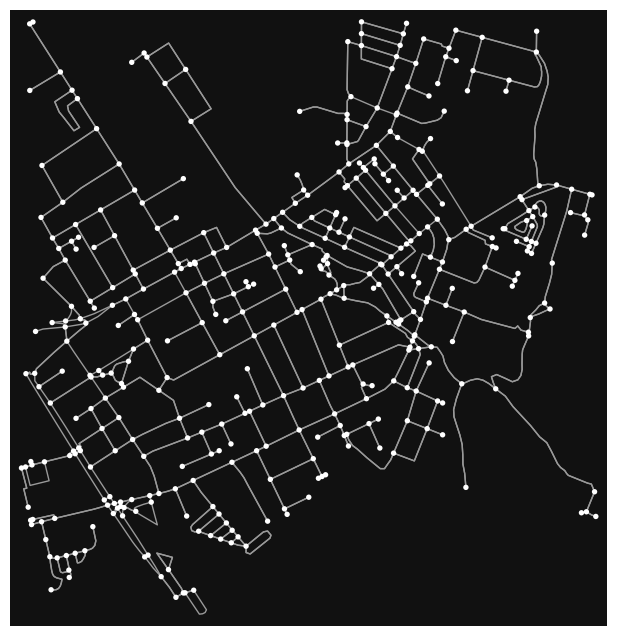

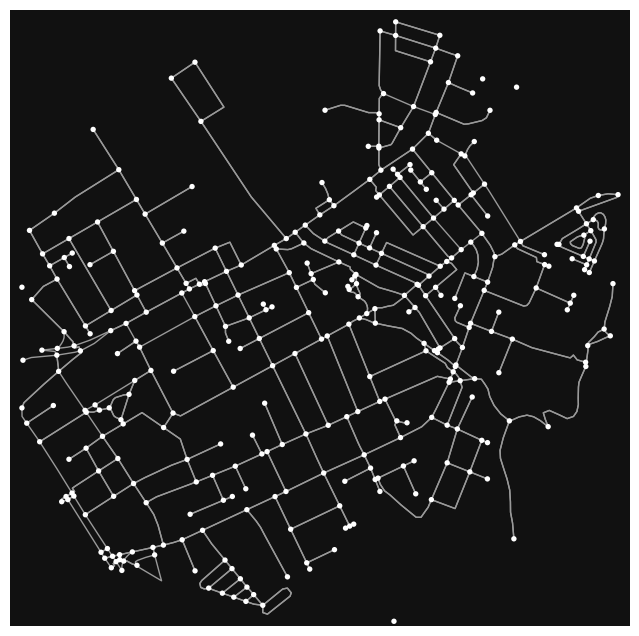

((<Figure size 800x800 with 1 Axes>, <Axes: >),
 (<Figure size 800x800 with 1 Axes>, <Axes: >))

In [13]:
# plot both subgraph and extracted graph from grid centroid
ox.plot_graph(testgraph), ox.plot_graph(subgraph_list[8447])

In [464]:
# get stats
stats = ox.stats.basic_stats(subgraph_list[8447], subgraph_area[8447])
stats

{'n': 360,
 'm': 898,
 'k_avg': 4.988888888888889,
 'edge_length_total': 35056.303000000014,
 'edge_length_avg': 39.03819933184857,
 'streets_per_node_avg': 2.7055555555555557,
 'streets_per_node_counts': {0: 0, 1: 75, 2: 3, 3: 235, 4: 47},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.20833333333333334,
  2: 0.008333333333333333,
  3: 0.6527777777777778,
  4: 0.13055555555555556},
 'intersection_count': 285,
 'street_length_total': 18354.825999999986,
 'street_segment_count': 470,
 'street_length_avg': 39.052821276595715,
 'circuity_avg': 1.0405280193698256,
 'self_loop_proportion': 0.00425531914893617,
 'node_density_km': 554.8775578025451,
 'intersection_density_km': 439.2780665936815,
 'edge_density_km': 54033.21053951678,
 'street_density_km': 28290.780624362917}

### Three-way-intersection density

### Street density

### Calculate distance from grid centroids to nearest bus stops

In [ ]:
start_time = time.time()

# Download street network of Greater Manchester from osmnx and project to CRS 27700
G = ox.graph_from_place('Greater Manchester', network_type='all', simplify=True)
Gproj = ox.project_graph(G, to_crs="27700")

# Save to graphml
ox.io.save_graphml(Gproj, 'network.graphml')

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

In [ ]:
# open graphml
Gproj = ox.load_graphml('network.graphml')

In [ ]:
directory = os.getcwd() #Location where files will be saved
c = "/"

In [10]:
# sub df with lat/lon values to get their nearest nodes for truncation
popgridsub = popgridmanchester.loc[200000:201000, ['geometry', 'grid_lon', 'grid_lat', 'grid_lon_4326', 'grid_lat_4326']]
popgridsub = gpd.GeoDataFrame(popgridsub, geometry='geometry')
popgridsub = popgridsub.reset_index()

In [11]:
# get bus stops
bus_stops = ox.geometries_from_place("Greater Manchester", tags={'highway': 'bus_stop'})
bus_stops = bus_stops.to_crs("EPSG:27700")
bus_stops = bus_stops[['geometry']]

In [12]:
# initiate function to get shortest path
def calculate_shortest_path(row):
    try:
        return nx.shortest_path_length(Gproj, valid_nodes_grid[row], valid_nodes_bus[row], weight='length')
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return None

In [13]:
# vectorized and adjusted version of getting the shortest distance to busstops. MUCH faster.

start_time = time.time()

# get nearest bus stops based on euclid distance, now via map() and lambda functions
polygon_index = popgridsub['geometry'].map(lambda row: bus_stops.distance(row, align=True).sort_values().index[0])
nearest_bus = bus_stops.loc[polygon_index].geometry.centroid

# list of grid centroid nearest nodes and their distances
nearest_nodes, dist = ox.distance.nearest_nodes(Gproj, popgridsub['grid_lon'],
                                                popgridsub['grid_lat'], return_dist=True)

# using vectorization instead of iterations through for-loops to get the nearest grid nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes, int)
nearest_nodes_grid = np.where(mask, nearest_nodes, np.nan)
dist_grid = np.where(mask, dist, np.nan)
valid_nodes_grid = np.array([nearest_nodes_grid, dist_grid], np.float64)
valid_nodes_grid = np.where(valid_nodes_grid[1]<1000, valid_nodes_grid[0], np.nan)

# list of bus stop nearest nodes and their distances
nearest_nodes_bus, dist_bus = ox.distance.nearest_nodes(Gproj, nearest_bus.geometry.x,
                                                nearest_bus.geometry.y, return_dist=True)

# using vectorization instead of iterations through for-loops to get the nearest bus stop nodes with
# a threshold. MUCH faster.
mask = np.vectorize(isinstance)(nearest_nodes_bus, int)
nearest_nodes_b = np.where(mask, nearest_nodes_bus, np.nan)
dist_bus = np.where(mask, dist_bus, np.nan)
valid_nodes_bus = np.array([nearest_nodes_bus, dist_bus], np.float64)
valid_nodes_bus = np.where(valid_nodes_bus[1]<1000, valid_nodes_bus[0], np.nan)

# Get the shortest distance by calling the function one cell above that uses nx.shortest_path_length()
popgridsub['dist_to_busstop'] = [calculate_shortest_path(x) for x in popgridsub.index]

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")

Execution time: 12.204354524612427 seconds


In [ ]:
df.to_file('popgriddistance.gpkg', driver='GPKG')

### Overlay with health outcome data

In [ ]:
# match the crs to the health data crs
popgridmanchester = popgridmanchester.to_crs("epsg:27700")

In [ ]:
# create overlay with the health outcome data
overlay = data_health.overlay(popgridmanchester, how='intersection')

In [ ]:
# save overlay
overlay.to_file("overlay.gpkg", driver="GPKG")